
----------------------------------------

## Problem Statement: 
-----------------------------

The program helps people to achieve five goals: increase net worth, avoid eviction, obtain safe housing, receive house vouchers and improve food access. The total number of people attending the program was 450 (unique clients).  About 40% of clients had no income at the moment of enrollment. The size of household ranged from 1 to 7. The caseworkers provided more than 3000 various services and opened 600 cases. There were categorical and numerical data collected about the target group. Based on it, our team wants to understand if collected data can segment the target group to better planning of future program activities.


----------------------------
## Objective: 
-----------------------------

Identify different segments in the existing clients based on their income, age, household size as well as days in program, number of services received, goals attempted etc.

--------------------------
## About the data:
--------------------------

The dataset has the following variables:

- Program Year - Year
- Age - age of client
- Income - annual income of client
- Houshold size - number of people living in the household
- Number of services - total number of services of client per program year
- Duration  - Number of days(calculated the date when the case was opened and the day when outcome was achieved)
- Goals  - Number of goals set to acheive


## Importing libraries and overview of the dataset

In [145]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [146]:
data = pd.read_csv("data.csv")
data.head()

,Year,Result,Nresult,Age,Household,Income,Service,Duration,Goals
0,2020,No,0,48,1,24235,7,211,1
1,2020,Yes,1,41,4,21580,8,28,1
2,2020,Yes,1,51,1,11856,2,13,1
3,2020,Yes,1,35,6,10608,3,1,1
4,2020,No,0,33,1,32552,26,314,2


#### Check the info of the data

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       435 non-null    int64 
 1   Result     435 non-null    object
 2   Nresult    435 non-null    int64 
 3   Age        435 non-null    int64 
 4   Household  435 non-null    int64 
 5   Income     435 non-null    int64 
 6   Service    435 non-null    int64 
 7   Duration   435 non-null    int64 
 8   Goals      435 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 28.9+ KB


**Observations:**

- There are 435 observations and 9 columns in the dataset.
- There are no missing values.
- Three variables should be dropped before analysis. Kmeans does not deal with categorical, dummy or year data.


In [148]:
### drop columns 
data=data.drop(['Result', 'Year', 'Nresult'], axis=1)
data.head(2)

,Age,Household,Income,Service,Duration,Goals
0,48,1,24235,7,211,1
1,41,4,21580,8,28,1


## Exploratory Data Analysis

#### Summary Statistics

In [172]:
data.describe()

,Age,Household,Income,Service,Duration,Goals,Labels
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,43.144828,1.767816,17328.218391,7.243678,91.613793,1.188506,1.351724
std,13.097637,1.322919,14559.270088,8.439562,100.194662,0.481316,0.802051
min,19.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,33.500000,1.000000,6576.000000,2.000000,14.000000,1.000000,1.000000
50%,41.000000,1.000000,14897.000000,4.000000,48.000000,1.000000,2.000000
75%,51.000000,2.000000,24476.500000,10.000000,146.500000,1.000000,2.000000
max,86.000000,7.000000,74446.000000,59.000000,364.000000,4.000000,2.000000


**Observations:**

-  The average age of client is 43 with standard deviation (SD) of 13. High SD speaks for the high degree of variance in the age variable. The youngest client is 19 whereas the oldest is 86. About 50% of clients enrolled in the program are between 33 and 51 years old.
-  The average size of household is 2 with SD 1.32. The maximum household size is 7. Most families in the program had 1 to 3 persons in the household.
-   The mean of services is 7.2 with SD of 8.4. The range of services is from 1 - min, and 59 max. 50% of clients received from 2 to 10 services.
-  On average clients enroll into one goal. The maximum number of goals enrolled is 4.
-  The average duration of stay in program is 91 days with SD of 100. The data also shows that many clients stayed one day in program; looks like received service, achieved outcome, and closed the case. 50% of clients stayed between 14 and 147 days.


**Data distribution:** 

Age
Skew : 0.6


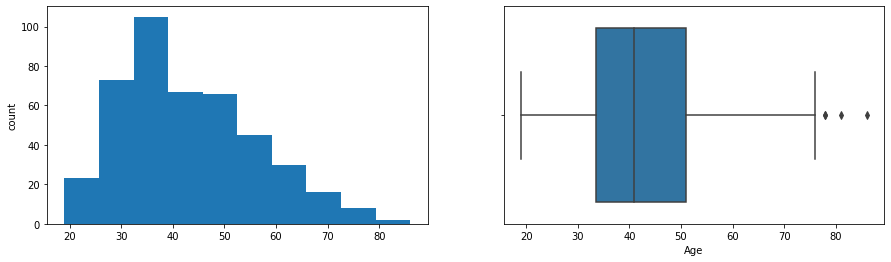

Household
Skew : 1.6


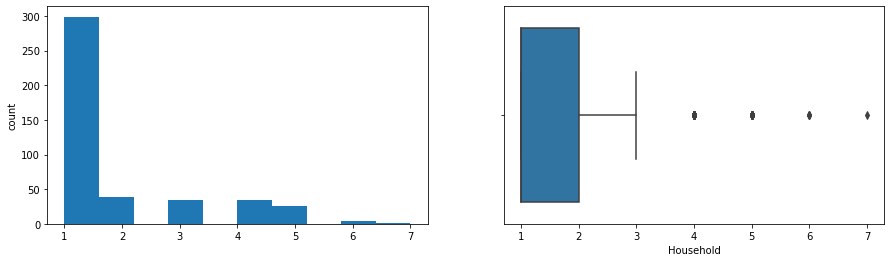

Income
Skew : 0.92


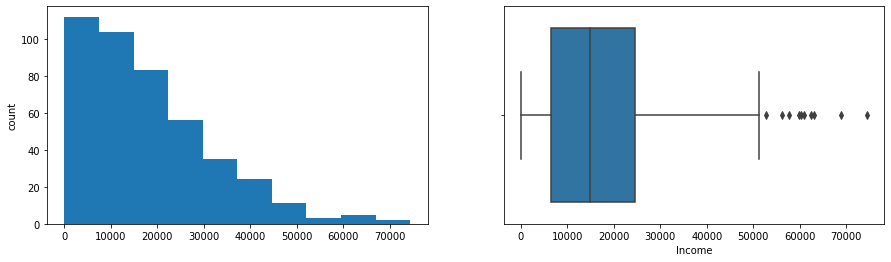

Service
Skew : 2.53


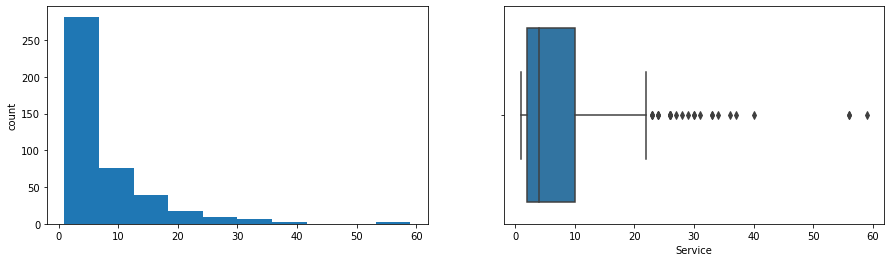

Duration
Skew : 1.14


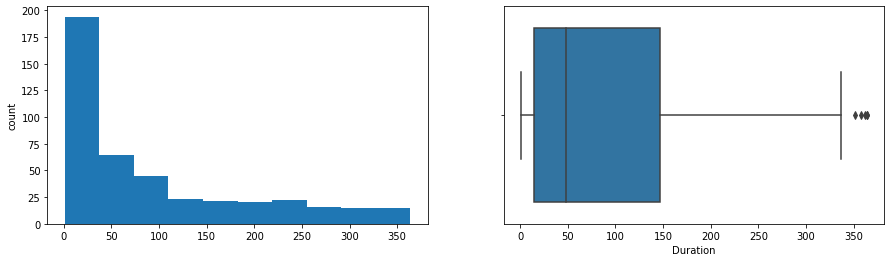

Goals
Skew : 3.08


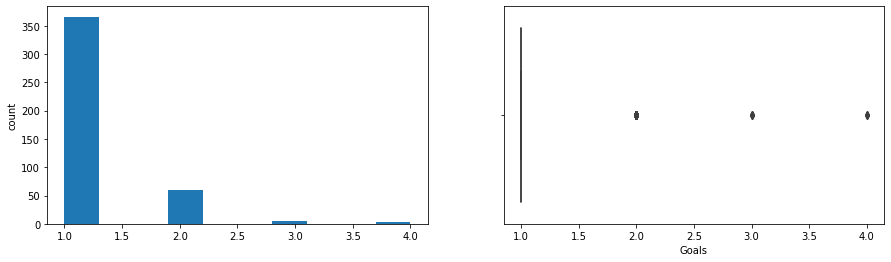

In [98]:
for col in data.columns:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- It looks like for most cases data skewed to the right.
- Up to 75% of clients received about or less than 20 services. There are also clients that received more than 20.  
- About 75% of clients stayed in program from 1 to 150 days.


**Correlation among different variables.**

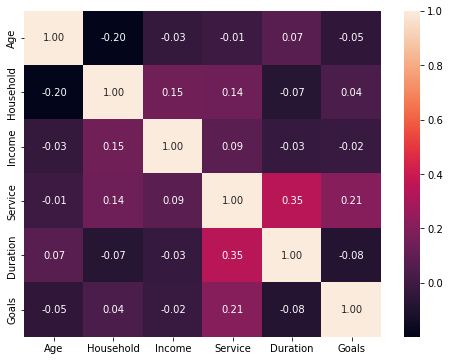

In [151]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
plt.show()

**Observations:**

- Duration (number of days) is positively correlated with number of services which makes sense. The longer person is in program the more services s/he is likely to receive.
- Age is negatively correlated with household size. 
- Number of goals is positively correlated with services. Increase in goals require additional services.

#### Scaling the data

In [152]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [153]:
data_scaled.head()

,Age,Household,Income,Service,Duration,Goals
0,0.371118,-0.581064,0.474937,-0.028907,1.192915,-0.392098
1,-0.163945,1.689260,0.292369,0.089719,-0.635633,-0.392098
2,0.600430,-0.581064,-0.376291,-0.622037,-0.785514,-0.392098
3,-0.622571,3.202810,-0.462108,-0.503411,-0.905419,-0.392098
4,-0.775446,-0.581064,1.046846,2.224987,2.222097,1.687933


In [154]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

## K-Means

To find out the optimum number of clusters to use, I will plot the SSE

**Observations:**
- Looking at the plot, I choose k=3.

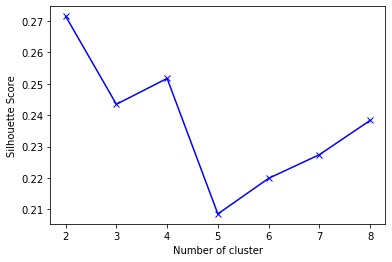

In [167]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()


**Fitting the K-means algorithms on the scaled data with number of cluster equal to 3 and Storing the predictions as 'Labels' to the 'data_scaled_copy' and 'data' dataframes**

In [168]:
kmeans = KMeans(n_clusters=3, max_iter= 1000, random_state=1)
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['Labels'] = kmeans.predict(data_scaled)
data['Labels'] = kmeans.predict(data_scaled)

#### **Creating cluster profiles using the below summary statistics and box plots for each label**

In [171]:
#Number of observations in each cluster
data.Labels.value_counts()

2    243
1    102
0     90
Name: Labels, dtype: int64

In [169]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('Labels').mean()
median = data.groupby('Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean',
                   'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Age,36.688889,46.735294,44.028807,37.0,46.0,42.0
Household,3.922222,1.313725,1.160494,4.0,1.0,1.0
Income,24123.877778,16766.058824,15047.275720,21736.0,14518.0,13764.0
Service,9.411111,14.088235,3.567901,8.0,11.0,2.0
Duration,56.044444,239.107843,42.876543,30.0,243.5,29.0
Goals,1.355556,1.147059,1.144033,1.0,1.0,1.0


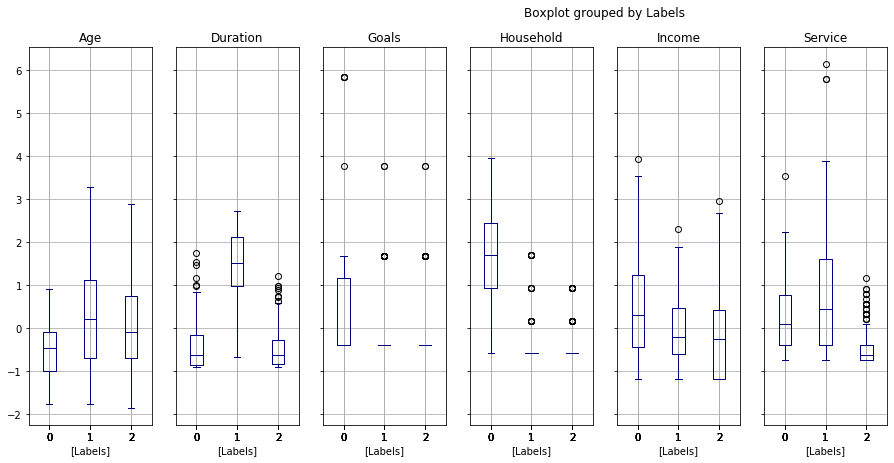

In [187]:
#Visualizing different features w.r.t K-means labels
data_scaled_copy.boxplot(by = 'Labels', color="navy",layout = (1,8),figsize=(20,7))

plt.show()

**Clients Profiles:**

- Client_0 - This cluster represents younger clients with household of 3. They usually target 2 goals while receiving on average 9 services and staying in program for almost two months. This cluster has higher level of income in comparison to other two clusters.
- Client_1 - This cluster represents older clients with 2 persons in household. Out of three suggested groups they stay longer in program up to 8 months. On average they also receive more services than other 2 groups. They are likely to work on two goals. These clients are enrolled in house search as well as eviction goals.
- Client_2 - This cluster represents clients who receive not so many services but stay up to 42 days in program. This fact tells that they are likely to focus on increase of worth net. This is usually single person in the household with lowest income out of two other groups.
